# Facial Keypoint Detection 

## 1. Import packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
import tensorflow.keras.layers as tfl
import pandas as pd
import zipfile
from sklearn.model_selection import train_test_split
from hyperopt import tpe, Trials
from hyperas import optim

2023-10-03 17:08:22.101304: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-03 17:08:22.953990: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
tf.config.experimental_run_functions_eagerly(True)
tf.config.run_functions_eagerly(True)
tf.data.experimental.enable_debug_mode()

Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.


## 2. Data preparation

### 2.1 Loading data

In [3]:
with zipfile.ZipFile('facial-keypoints-detection/training.zip', 'r') as zip_ref:
    zip_ref.extractall()
with zipfile.ZipFile('facial-keypoints-detection/test.zip', 'r') as zip_ref:
    zip_ref.extractall()
with zipfile.ZipFile('facial-keypoints-detection.zip', 'r') as zip_ref:
    zip_ref.extractall()

In [4]:
def get_data():
    train_val_df = pd.read_csv('training.csv')
    train_val_df_x = train_val_df['Image'].apply(lambda x: np.array(x.split(' '), dtype='int'))
    train_val_df_x = np.stack(train_val_df_x, axis = 0).reshape(-1, 96, 96)/255.0
    
    features_names = train_val_df.columns[:-1]
    train_val_df_y = train_val_df[features_names]

    test_df = pd.read_csv('test.csv')
    test_df_x = test_df['Image'].apply(lambda x: np.array(x.split(' '), dtype='int'))
    test_df_x = np.stack(test_df_x, axis = 0).reshape(-1, 96, 96)/255.0
    
    return train_val_df, train_val_df_x, train_val_df_y, test_df, test_df_x

In [5]:
train_val_df, train_val_df_x, train_val_df_y, test_df, test_df_x = get_data()

In [6]:
train_val_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7049 entries, 0 to 7048
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   left_eye_center_x          7039 non-null   float64
 1   left_eye_center_y          7039 non-null   float64
 2   right_eye_center_x         7036 non-null   float64
 3   right_eye_center_y         7036 non-null   float64
 4   left_eye_inner_corner_x    2271 non-null   float64
 5   left_eye_inner_corner_y    2271 non-null   float64
 6   left_eye_outer_corner_x    2267 non-null   float64
 7   left_eye_outer_corner_y    2267 non-null   float64
 8   right_eye_inner_corner_x   2268 non-null   float64
 9   right_eye_inner_corner_y   2268 non-null   float64
 10  right_eye_outer_corner_x   2268 non-null   float64
 11  right_eye_outer_corner_y   2268 non-null   float64
 12  left_eyebrow_inner_end_x   2270 non-null   float64
 13  left_eyebrow_inner_end_y   2270 non-null   float

### 2.2 Describing data

In [7]:
def display_null_plot(null_stats: pd.DataFrame):
    plt.figure(figsize = (12, 6))
    total_percentage = plt.bar(null_stats.index, null_stats['total_percentage'], label = 'total percentage')
    null_percentage = plt.bar(null_stats.index, null_stats['null_percentage'], label = 'percentage of null values')
    for rect in null_percentage:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                f"{'%d' % height}", ha = 'center', va = 'bottom')
    plt.xticks(rotation = 90)
    plt.title('Percentage of null values each feature')
    plt.legend()
    plt.show()

In [8]:
def null_stats(df: pd.DataFrame, display = True, sort = False) -> pd.DataFrame:
    null_stats = pd.DataFrame(df.isna().sum(), columns = ['null_count'])
    null_stats['total_values'] = [len(df)]*len(null_stats)
    null_stats['null_percentage'] = null_stats['null_count']/null_stats['total_values']
    null_stats['null_percentage'] = null_stats['null_percentage']*100
    null_stats['null_percentage'] = null_stats['null_percentage'].round(2)
    null_stats['total_percentage'] = [100]*len(null_stats)
    if sort:
        null_stats.sort_values(by = 'null_percentage', ascending = False, inplace = True)
    if display:
        display_null_plot(null_stats)
    return null_stats

In [9]:
train_val_df.describe()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
count,7039.000000,7039.000000,7036.000000,7036.000000,2271.000000,2271.000000,2267.000000,2267.000000,2268.000000,2268.000000,...,7049.000000,7049.000000,2269.000000,2269.000000,2270.000000,2270.000000,2275.000000,2275.000000,7016.000000,7016.000000
mean,66.359021,37.651234,30.306102,37.976943,59.159339,37.944752,73.330478,37.707008,36.652607,37.989902,...,48.374186,62.715884,63.285735,75.970714,32.900404,76.179768,47.975412,72.919443,48.569472,78.970146
std,3.448233,3.152926,3.083230,3.033621,2.690354,2.307332,3.405852,2.881438,2.350268,2.311907,...,4.280038,5.720567,4.079063,4.579724,3.964552,4.417814,3.323060,5.222500,4.269961,5.407844
min,22.763345,1.616512,0.686592,4.091264,19.064954,27.190098,27.571879,26.250023,5.751046,26.250023,...,12.944699,17.932414,22.923362,57.023258,2.245766,56.690208,12.605173,56.719043,12.536477,25.850503
25%,65.082895,35.900451,28.783339,36.327681,58.039339,36.626283,71.716503,36.085523,35.506126,36.766783,...,46.602370,59.292697,61.257143,72.875707,30.797646,73.256472,46.494571,69.396748,46.573703,75.549715
50%,66.497566,37.528055,30.251378,37.813273,59.304615,37.878040,73.247824,37.639015,36.651562,37.944075,...,48.424713,63.451421,63.178286,75.778689,32.982305,76.000592,47.905490,72.605173,48.594978,78.696326
75%,68.024752,39.258449,31.768334,39.566729,60.519810,39.260348,75.015645,39.373489,37.753571,39.192917,...,50.330437,66.492686,65.376243,78.879123,35.101302,78.956357,49.296488,76.221644,50.677631,82.233993
max,94.689280,80.502649,85.039381,81.270911,84.440991,66.562559,95.258090,64.618230,70.714966,69.808803,...,89.438592,95.935644,84.767123,94.673637,74.017993,95.510678,83.989082,94.548359,89.438592,95.808983


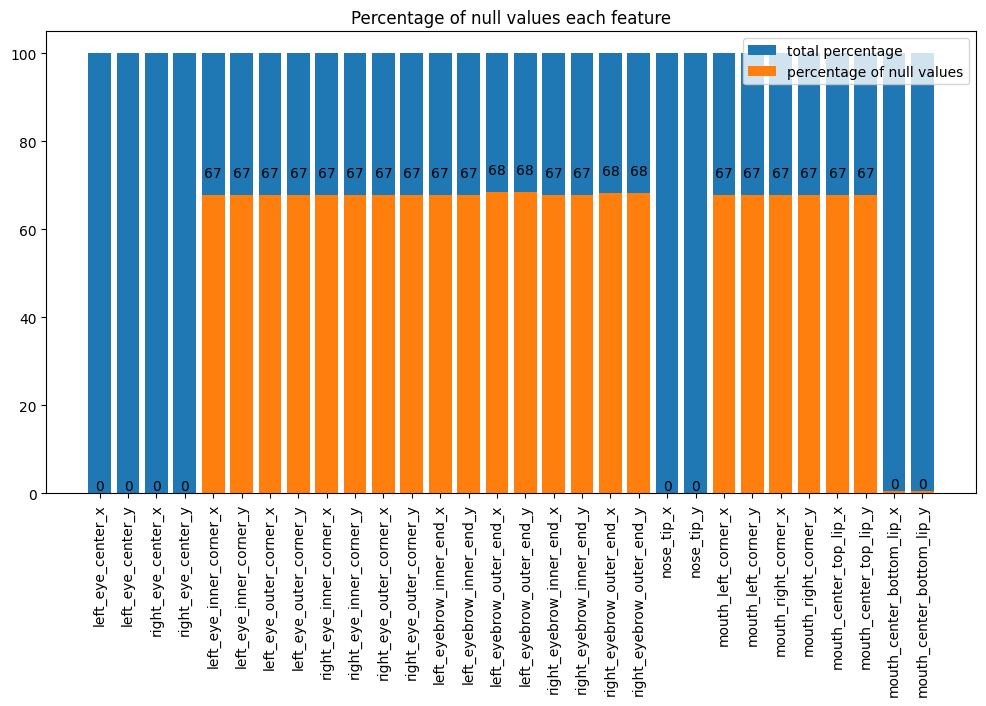

In [10]:
null_stats_train_val_df_y = null_stats(train_val_df_y)

In [11]:
display(null_stats_train_val_df_y)

,null_count,total_values,null_percentage,total_percentage
left_eye_center_x,10,7049,0.14,100
left_eye_center_y,10,7049,0.14,100
right_eye_center_x,13,7049,0.18,100
right_eye_center_y,13,7049,0.18,100
left_eye_inner_corner_x,4778,7049,67.78,100
left_eye_inner_corner_y,4778,7049,67.78,100
left_eye_outer_corner_x,4782,7049,67.84,100
left_eye_outer_corner_y,4782,7049,67.84,100
right_eye_inner_corner_x,4781,7049,67.83,100
right_eye_inner_corner_y,4781,7049,67.83,100


### 2.3 Describing new datasets after fixing null values

#### I. Filling null values with mean value for each column in DataFrame

In [12]:
def train_val_df_with_filling_null():
    train_val_df, train_val_df_x, filling_null_train_val_df_y, test_df, test_df_x = get_data()
    train_val_df = pd.read_csv('training.csv')
    train_val_df_x = train_val_df['Image'].apply(lambda x: np.array(x.split(' '), dtype = 'int'))
    train_val_df_x = np.stack(train_val_df_x, axis = 0).reshape(-1, 96, 96)/255.0
    
    features_names = train_val_df.columns[:-1]
    filling_null_train_val_df_y = train_val_df[features_names]

    for i in filling_null_train_val_df_y.columns[:]:
        filling_null_train_val_df_y[i].fillna(filling_null_train_val_df_y[i].mean(), inplace = True)
        
    filling_null_train_df_x, filling_null_val_df_x, filling_null_train_df_y, filling_null_val_df_y = train_test_split(train_val_df_x, 
                                                                            filling_null_train_val_df_y, test_size = 0.3, random_state = 32)
    return filling_null_train_df_x, filling_null_val_df_x, filling_null_train_df_y, filling_null_val_df_y 

In [13]:
filling_null_train_df_x, filling_null_val_df_x, filling_null_train_df_y, filling_null_val_df_y = train_val_df_with_filling_null()
filling_null_train_val_df_y = pd.concat([filling_null_train_df_y, filling_null_val_df_y]).sort_index()

/tmp/ipykernel_2456/2543992098.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filling_null_train_val_df_y[i].fillna(filling_null_train_val_df_y[i].mean(), inplace = True)


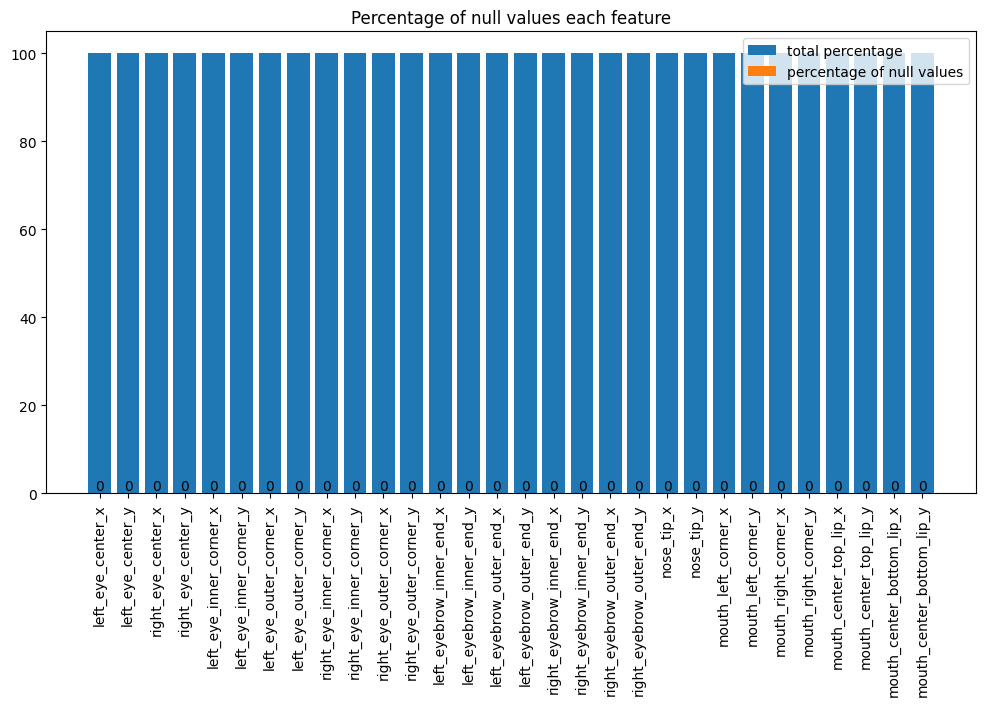

In [14]:
null_stats_filling_null_train_val_df_y = null_stats(filling_null_train_val_df_y)

#### II. Deleting rows with null values

In [15]:
def train_val_df_without_null_rows():
    train_val_df, train_val_df_x, train_val_df_y, test_df, test_df_x = get_data()
    
    without_null_train_val_df = pd.DataFrame(train_val_df.dropna())

    features_names = train_val_df.columns[:-1]
    without_null_train_val_df_y = without_null_train_val_df[features_names]

    without_null_train_val_df_x = without_null_train_val_df['Image'].apply(lambda x: np.array(x.split(' '), dtype = 'int'))
    without_null_train_val_df_x = np.stack(without_null_train_val_df_x, axis = 0).reshape(-1, 96, 96)/255.0

    without_null_train_df_x, without_null_val_df_x, without_null_train_df_y, without_null_val_df_y = train_test_split(
        without_null_train_val_df_x, without_null_train_val_df_y, test_size = 0.3, random_state = 32)
    return without_null_train_df_x, without_null_val_df_x, without_null_train_df_y, without_null_val_df_y 

In [16]:
without_null_train_df_x, without_null_val_df_x, without_null_train_df_y, without_null_val_df_y = train_val_df_without_null_rows()
without_null_train_val_df_y = pd.concat([without_null_train_df_y, without_null_val_df_y])

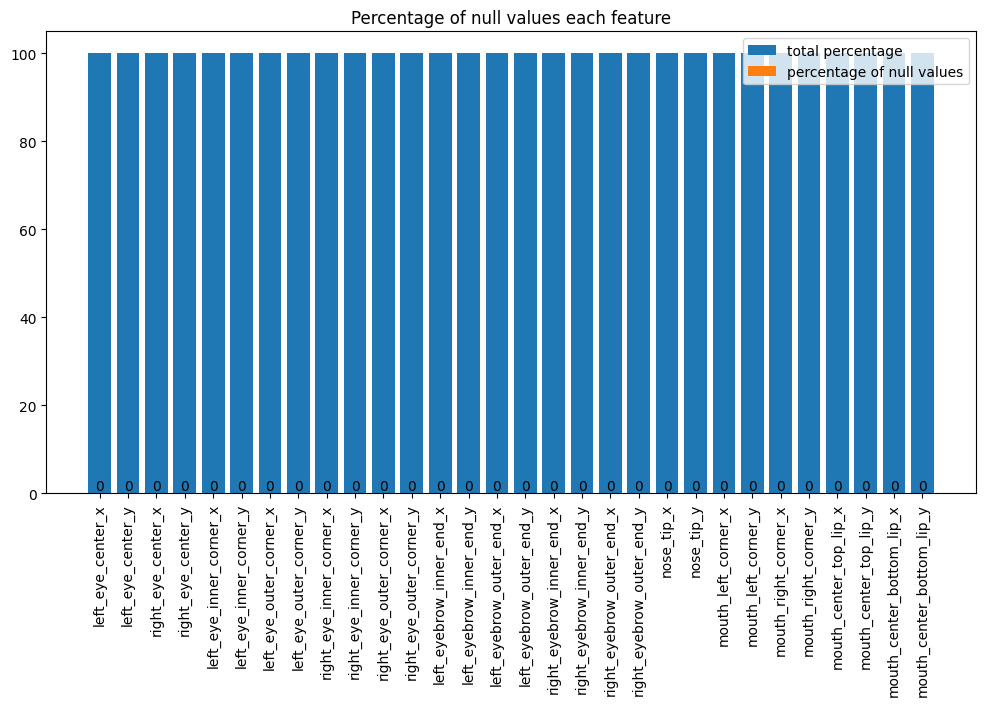

In [17]:
null_stats_without_null_train_val_df_y = null_stats(without_null_train_val_df_y)

#### III. Deleting columns, where percentage of null values are greater than 1%, rest is filled with mean value of the column

In [18]:
def train_val_df_less_features():
    train_val_df, train_val_df_x, train_val_df_y, test_df, test_df_x = get_data()
    
    null_filling_null_train_val_df_y = null_stats(train_val_df_y, False, False)

    less_features_names = []
    for idx in null_filling_null_train_val_df_y.index:
        if null_filling_null_train_val_df_y['null_percentage'][idx] < 1.00:
            less_features_names.append(idx)
            
    less_features_train_val_df_y = train_val_df[less_features_names]
    for i in less_features_train_val_df_y.columns[:]:
        less_features_train_val_df_y[i].fillna(less_features_train_val_df_y[i].mean(), inplace = True)

    less_features_train_df_x, less_features_val_df_x, less_features_train_df_y, less_features_val_df_y = train_test_split(train_val_df_x, 
        less_features_train_val_df_y, test_size = 0.3, random_state = 32)
    return less_features_train_df_x, less_features_val_df_x, less_features_train_df_y, less_features_val_df_y 

In [19]:
less_features_train_df_x, less_features_val_df_x, less_features_train_df_y, less_features_val_df_y = train_val_df_less_features()
less_features_train_val_df_y = pd.concat([less_features_train_df_y, less_features_val_df_y]).sort_index()

/tmp/ipykernel_2456/3279810597.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  less_features_train_val_df_y[i].fillna(less_features_train_val_df_y[i].mean(), inplace = True)


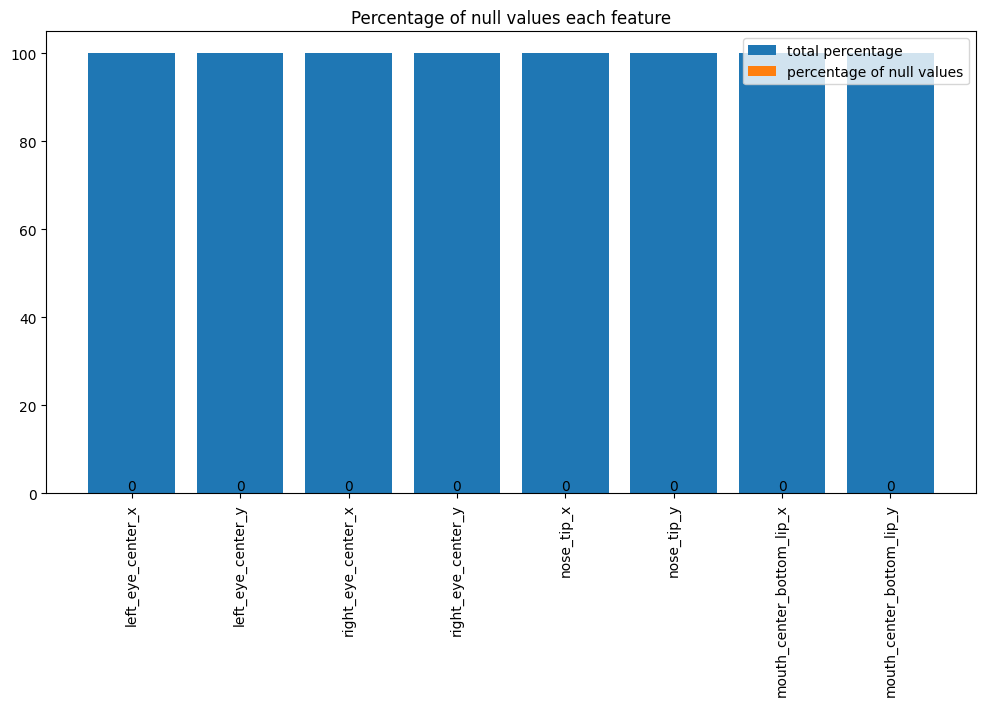

In [20]:
null_stats_less_features_train_val_df_y = null_stats(less_features_train_val_df_y)

### 2.4 Results of fixing null values

In [21]:
def display_grid(rows, cols, train_df_x, train_df_y_1, train_df_y_2 = None):
    plt.figure(figsize = (10, 10))
    for i in range(rows*cols):
        random_index = np.random.choice(len(train_df_x))
        plt.subplot(rows, cols, i+1)
        plt.imshow(train_df_x[random_index], cmap = 'gray')
        plt.scatter(train_df_y_1[random_index, :, 0], train_df_y_1[random_index, :, 1], marker = 'o', color = 'red')
        if train_df_y_2 is not None:
            plt.scatter(train_df_y_2[random_index, :, 0], train_df_y_2[random_index, :, 1], marker = 'x', color = 'blue')
    plt.show()

In [22]:
train_df_y_reshaped = train_val_df_y.values.reshape(train_val_df_y.shape[0], 15, 2)

#### I. Filling null values with mean value for each column in DataFrame

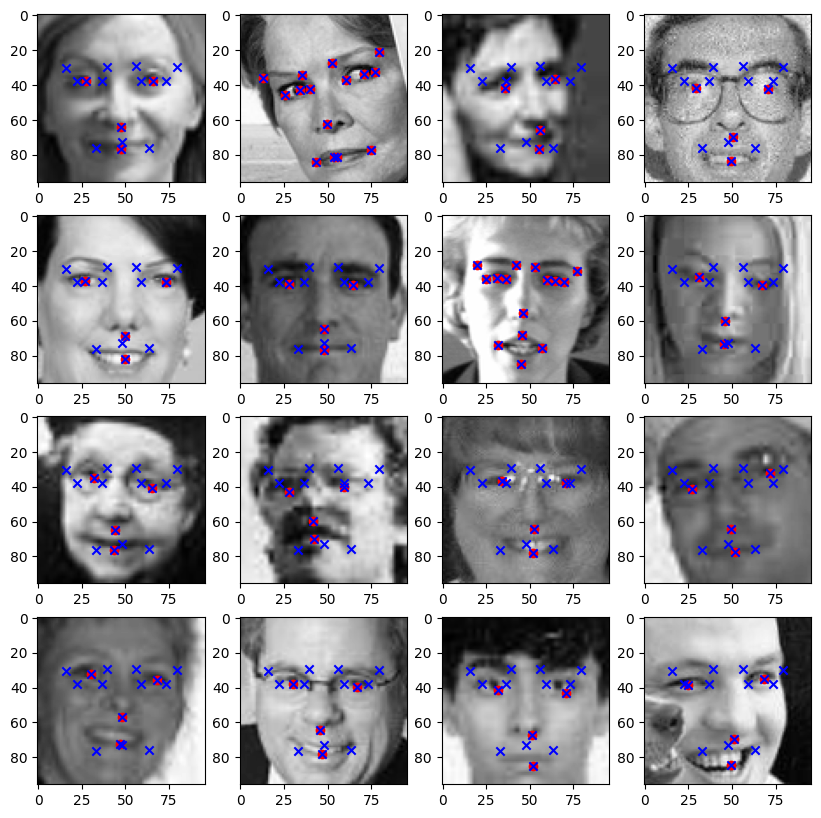

In [23]:
filling_null_train_val_df_y_reshaped = filling_null_train_val_df_y.values.reshape(filling_null_train_val_df_y.shape[0], 15, 2)
display_grid(4, 4, train_val_df_x, train_df_y_reshaped, filling_null_train_val_df_y_reshaped)

#### II. Deleting rows with null values

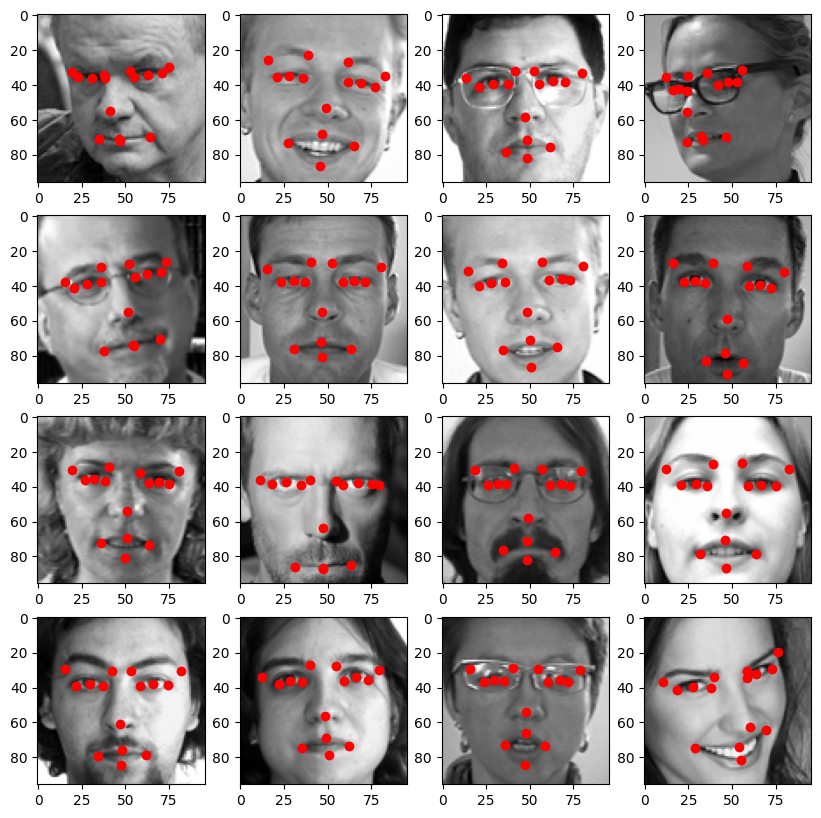

In [24]:
without_null_train_val_df_y_reshaped = without_null_train_val_df_y.values.reshape(without_null_train_val_df_y.shape[0], 15, 2)
display_grid(4, 4, np.append(without_null_train_df_x, without_null_val_df_x, axis = 0), without_null_train_val_df_y_reshaped)

#### III. Deleting columns, where percentage of null values are greater than 1%, rest is filled with mean value of the column

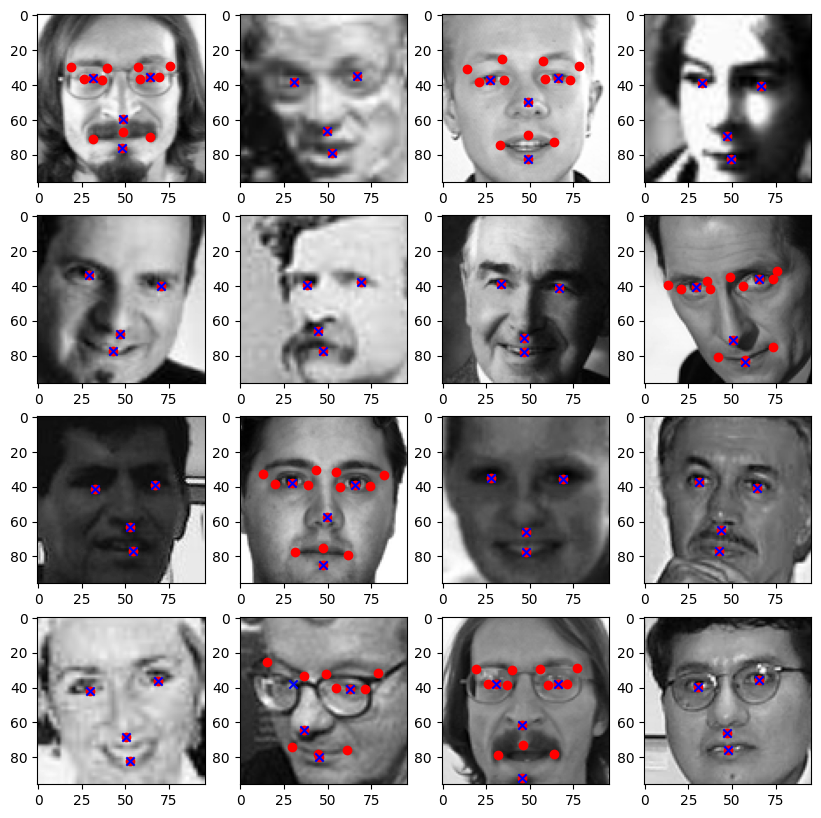

In [25]:
less_features_train_val_df_y_reshaped = less_features_train_val_df_y.values.reshape(less_features_train_val_df_y.shape[0], 4, 2)
display_grid(4, 4, train_val_df_x, train_df_y_reshaped, less_features_train_val_df_y_reshaped)

## 3. Model

In [26]:
epochs = 150
batch_size = 64

In [28]:
model = Sequential([
    tfl.Conv2D(filters = 38, kernel_size = 5, strides = (2, 2), padding = 'same', input_shape = (96, 96, 1)),
    tfl.BatchNormalization(axis = 3),
    tfl.ReLU(),
    tfl.MaxPool2D(pool_size = (3, 3), strides = (2, 2), padding = 'same'),
    
    tfl.Conv2D(filters = 114, kernel_size = 3, strides = (2, 2), padding = 'same'),
    tfl.BatchNormalization(axis = 3),
    tfl.ReLU(),
    
    tfl.Conv2D(filters = 196, kernel_size = 3, strides = (2, 2), padding = 'same'),
    tfl.BatchNormalization(axis = 3),
    tfl.ReLU(),
    
    tfl.Flatten(),
    tfl.Dense(500, activation = 'relu'),
    tfl.Dropout(0.2),
    tfl.Dense(30, activation = 'linear')
])

In [29]:
model = Sequential([
    tfl.Conv2D(filters = 38, kernel_size = 5, strides = (2, 2), padding = 'same', input_shape = (96, 96, 1)),
    tfl.BatchNormalization(axis = 3),
    tfl.ReLU(),
    tfl.MaxPool2D(pool_size = (3, 3), strides = (2, 2), padding = 'same'),
    
    tfl.Conv2D(filters = 114, kernel_size = 3, strides = (2, 2), padding = 'same'),
    tfl.BatchNormalization(axis = 3),
    tfl.ReLU(),
    
    tfl.Conv2D(filters = 196, kernel_size = 3, strides = (2, 2), padding = 'same'),
    tfl.BatchNormalization(axis = 3),
    tfl.ReLU(),
    
    tfl.Flatten(),
    tfl.Dense(512, activation = 'relu'),
    tfl.Dropout(0.1),
    tfl.Dense(30, activation = 'linear')
])

In [30]:
model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'mse', metrics = ['accuracy'])

### I. Filling null values with mean value for each column in DataFrame

In [31]:
history = model.fit(filling_null_train_df_x, filling_null_train_df_y, epochs = epochs, validation_data = 
                    (filling_null_val_df_x, filling_null_val_df_y), batch_size = batch_size, shuffle = True)

Epoch 1/150


2023-10-03 17:19:44.988957: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8904
2023-10-03 17:19:46.273031: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


78/78 [==============================] - 11s 88ms/step - loss: 145.6505 - accuracy: 0.3034 - val_loss: 748.5858 - val_accuracy: 0.5641
Epoch 2/150
78/78 [==============================] - 6s 81ms/step - loss: 22.9536 - accuracy: 0.4049 - val_loss: 309.8512 - val_accuracy: 0.5641
Epoch 3/150
78/78 [==============================] - 6s 81ms/step - loss: 18.2158 - accuracy: 0.4670 - val_loss: 82.6707 - val_accuracy: 0.1305
Epoch 4/150
78/78 [==============================] - 6s 81ms/step - loss: 15.8122 - accuracy: 0.5134 - val_loss: 61.1591 - val_accuracy: 0.5532
Epoch 5/150
78/78 [==============================] - 6s 82ms/step - loss: 14.2108 - accuracy: 0.5389 - val_loss: 69.1025 - val_accuracy: 0.5853
Epoch 6/150
78/78 [==============================] - 6s 81ms/step - loss: 12.5671 - accuracy: 0.5756 - val_loss: 44.5553 - val_accuracy: 0.6416
Epoch 7/150
78/78 [==============================] - 6s 81ms/step - loss: 12.0125 - accuracy: 0.6076 - val_loss: 18.1966 - val_accuracy: 0.7395


In [32]:
model.save('weights_filling_null.h5')

/home/aleksandra/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [33]:
model_filling_null = load_model('weights_filling_null.h5')

#### Model evaluation

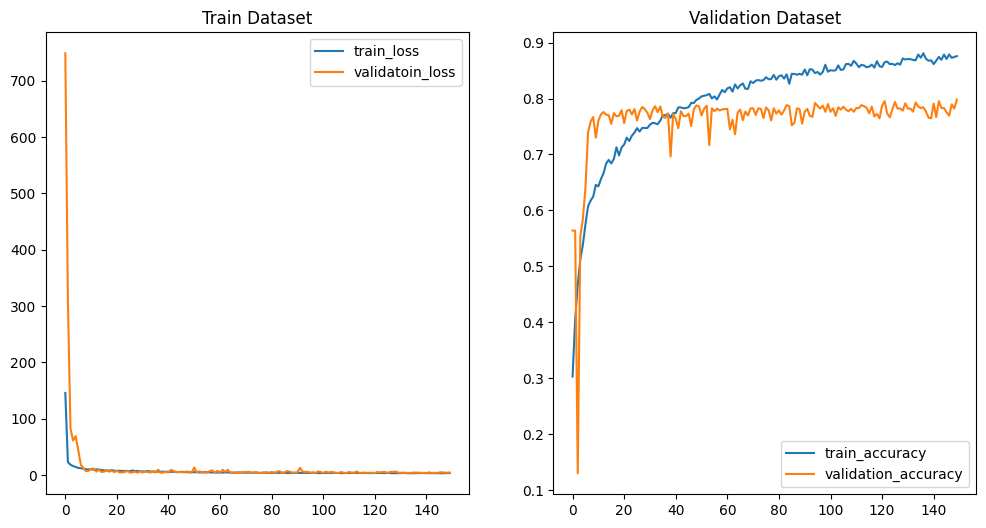

In [34]:
plt.figure(figsize = (12, 6))
plt.subplot(1, 2, 1)
plt.title('Train Dataset')
plt.plot(history.history['loss'], label = 'train_loss')
plt.plot(history.history['val_loss'], label = 'validatoin_loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.title('Validation Dataset')
plt.plot(history.history['accuracy'], label = 'train_accuracy')
plt.plot(history.history['val_accuracy'], label = 'validation_accuracy')
plt.legend()
plt.show()

In [35]:
preds = model_filling_null.predict(test_df_x)
display(preds)

56/56 [==============================] - 1s 19ms/step


array([[64.83992 , 35.814537, 28.63571 , ..., 68.37934 , 45.84224 ,
        81.692535],
       [65.84462 , 35.130188, 26.793852, ..., 70.80401 , 48.151833,
        82.35289 ],
       [64.61215 , 36.13114 , 31.05391 , ..., 70.29591 , 48.51043 ,
        80.83557 ],
       ...,
       [66.13675 , 41.214264, 33.033947, ..., 71.64138 , 44.33871 ,
        77.224075],
       [60.46829 , 34.66985 , 27.698082, ..., 70.4755  , 44.879433,
        70.398346],
       [67.54836 , 40.220543, 32.417595, ..., 74.09811 , 45.803535,
        79.35237 ]], dtype=float32)

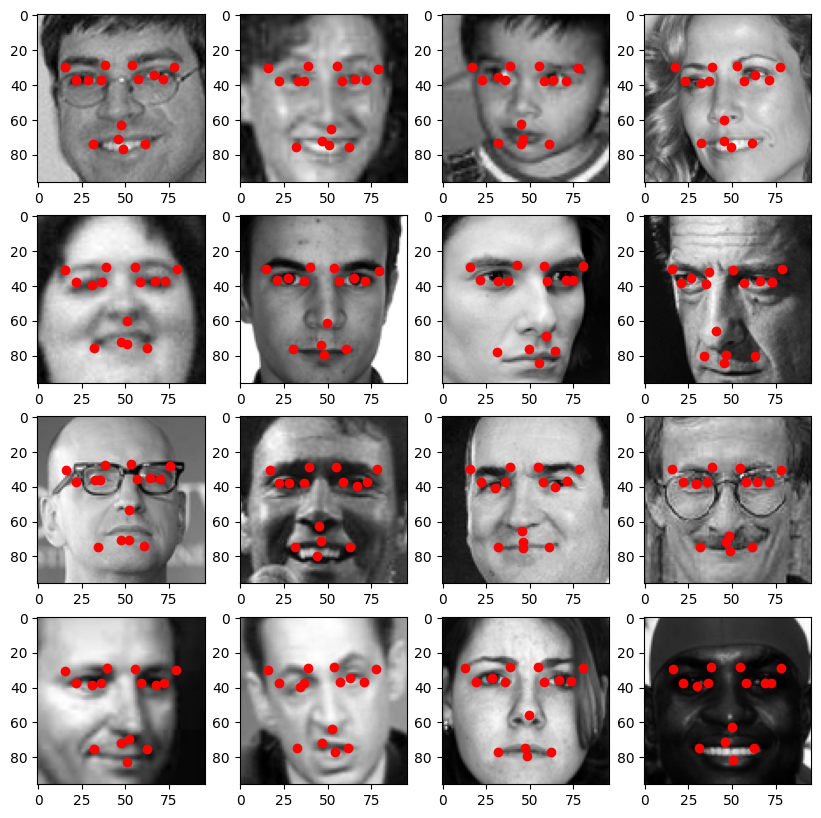

In [36]:
test_df_y_reshaped = preds.reshape(len(preds), 15, 2)
display_grid(4, 4, test_df_x, test_df_y_reshaped)

### II. Deleting rows with null values

In [42]:
history = model.fit(without_null_train_df_x, without_null_train_df_y, epochs = epochs, batch_size = batch_size, 
                    validation_data = (without_null_val_df_x, without_null_val_df_y), shuffle = True)

Epoch 1/150
24/24 [==============================] - 2s 74ms/step - loss: 4.8519 - accuracy: 0.8124 - val_loss: 3.3166 - val_accuracy: 0.8567
Epoch 2/150
24/24 [==============================] - 1s 62ms/step - loss: 4.2354 - accuracy: 0.8204 - val_loss: 3.8551 - val_accuracy: 0.8567
Epoch 3/150
24/24 [==============================] - 2s 69ms/step - loss: 3.7310 - accuracy: 0.8164 - val_loss: 2.7776 - val_accuracy: 0.8567
Epoch 4/150
24/24 [==============================] - 2s 66ms/step - loss: 3.6534 - accuracy: 0.8271 - val_loss: 3.5362 - val_accuracy: 0.8707
Epoch 5/150
24/24 [==============================] - 2s 65ms/step - loss: 3.4946 - accuracy: 0.8291 - val_loss: 6.3407 - val_accuracy: 0.8738
Epoch 6/150
24/24 [==============================] - 1s 58ms/step - loss: 3.8672 - accuracy: 0.8104 - val_loss: 2.8413 - val_accuracy: 0.8801
Epoch 7/150
24/24 [==============================] - 1s 58ms/step - loss: 3.6681 - accuracy: 0.8378 - val_loss: 2.9083 - val_accuracy: 0.8676
Epoch 

In [43]:
model.save('weights_without_null.h5')

/home/aleksandra/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [44]:
model_without_null = load_model('weights_without_null.h5')

#### Model evaluation

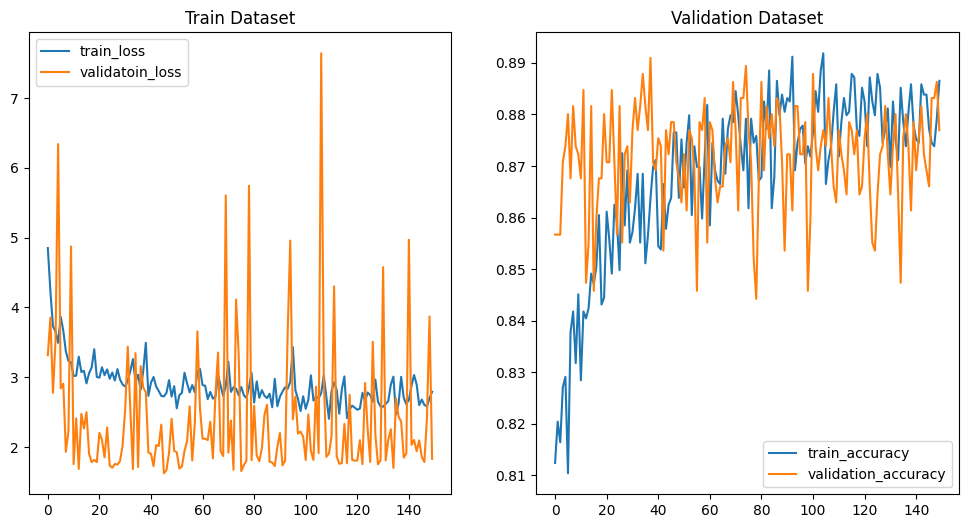

In [45]:
plt.figure(figsize = (12, 6))
plt.subplot(1, 2, 1)
plt.title('Train Dataset')
plt.plot(history.history['loss'], label = 'train_loss')
plt.plot(history.history['val_loss'], label = 'validatoin_loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.title('Validation Dataset')
plt.plot(history.history['accuracy'], label = 'train_accuracy')
plt.plot(history.history['val_accuracy'], label = 'validation_accuracy')
plt.legend()
plt.show()

In [46]:
preds = model_without_null.predict(test_df_x)
display(preds)

56/56 [==============================] - 1s 18ms/step


array([[65.30136 , 37.04946 , 29.230385, ..., 68.595024, 47.561474,
        81.80123 ],
       [66.71639 , 36.533745, 27.57338 , ..., 72.63078 , 48.77655 ,
        86.84972 ],
       [65.16211 , 35.848377, 30.806065, ..., 70.25452 , 49.03304 ,
        81.893555],
       ...,
       [66.321236, 39.147728, 31.545052, ..., 73.29885 , 44.58805 ,
        78.01126 ],
       [64.366165, 36.369686, 28.465765, ..., 72.983185, 45.889915,
        74.59046 ],
       [65.86085 , 38.602703, 31.224697, ..., 74.91572 , 46.525673,
        80.82872 ]], dtype=float32)

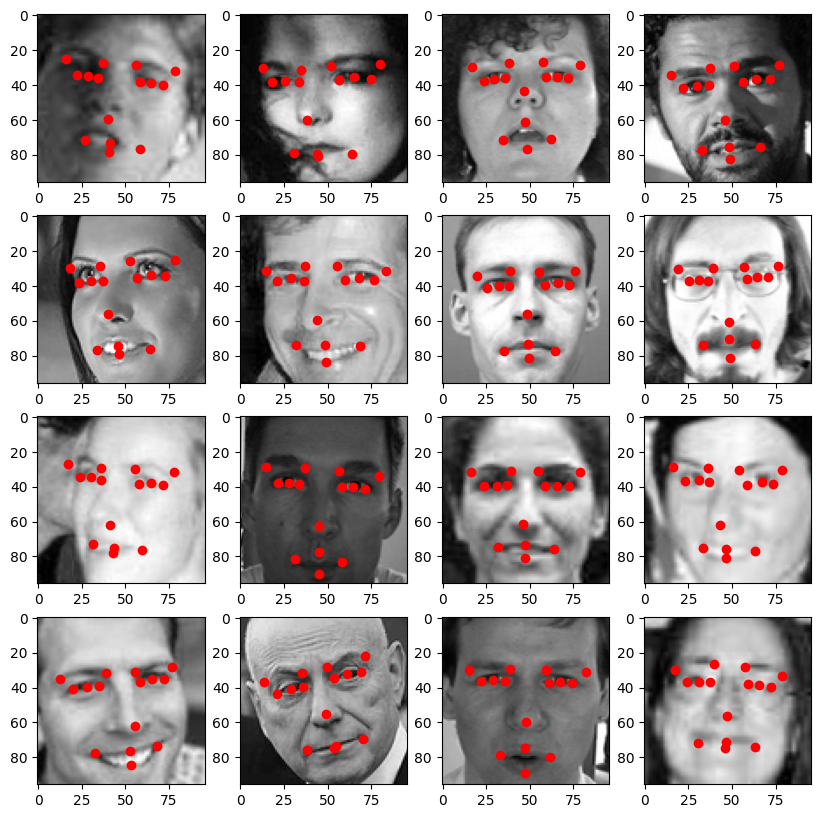

In [47]:
test_df_y_reshaped = preds.reshape(len(preds), 15, 2)
display_grid(4, 4, test_df_x, test_df_y_reshaped)

### III. Deleting columns, where percentage of null values are greater than 1%, rest is filled with mean value of the column

In [48]:
model_less_features = Sequential([
    tfl.Conv2D(filters = 38, kernel_size = 5, strides = (2, 2), padding = 'same', input_shape = (96, 96, 1)),
    tfl.BatchNormalization(axis = 3),
    tfl.ReLU(),
    tfl.MaxPool2D(pool_size = (3, 3), strides = (2, 2), padding = 'same'),
    
    tfl.Conv2D(filters = 114, kernel_size = 3, strides = (2, 2), padding = 'same'),
    tfl.BatchNormalization(axis = 3),
    tfl.ReLU(),
    
    tfl.Conv2D(filters = 196, kernel_size = 3, strides = (2, 2), padding = 'same'),
    tfl.BatchNormalization(axis = 3),
    tfl.ReLU(),
    
    tfl.Flatten(),
    tfl.Dense(512, activation = 'relu'),
    tfl.Dropout(0.1),
    tfl.Dense(8, activation = 'linear')
])

In [49]:
model_less_features.compile(optimizer = 'adam', loss = 'mse', metrics = ['accuracy'])

In [50]:
history = model_less_features.fit(less_features_train_df_x, less_features_train_df_y, epochs = epochs, batch_size = 
                                  batch_size, validation_data = (less_features_val_df_x, less_features_val_df_y))

Epoch 1/150
78/78 [==============================] - 7s 89ms/step - loss: 124.1135 - accuracy: 0.9676 - val_loss: 657.5787 - val_accuracy: 0.9915
Epoch 2/150
78/78 [==============================] - 7s 90ms/step - loss: 23.3961 - accuracy: 0.9854 - val_loss: 179.8059 - val_accuracy: 0.9915
Epoch 3/150
78/78 [==============================] - 7s 86ms/step - loss: 20.2214 - accuracy: 0.9864 - val_loss: 36.7544 - val_accuracy: 0.9915
Epoch 4/150
78/78 [==============================] - 7s 84ms/step - loss: 17.4067 - accuracy: 0.9860 - val_loss: 64.3444 - val_accuracy: 0.9915
Epoch 5/150
78/78 [==============================] - 6s 79ms/step - loss: 15.5270 - accuracy: 0.9866 - val_loss: 47.8218 - val_accuracy: 0.9915
Epoch 6/150
78/78 [==============================] - 7s 85ms/step - loss: 15.0482 - accuracy: 0.9899 - val_loss: 37.6562 - val_accuracy: 0.9915
Epoch 7/150
78/78 [==============================] - 7s 85ms/step - loss: 13.7953 - accuracy: 0.9884 - val_loss: 14.5402 - val_accura

In [51]:
model_less_features.save('weights_less_features.h5')

/home/aleksandra/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [52]:
model_less_features = load_model('weights_less_features.h5')

#### Model evaluation

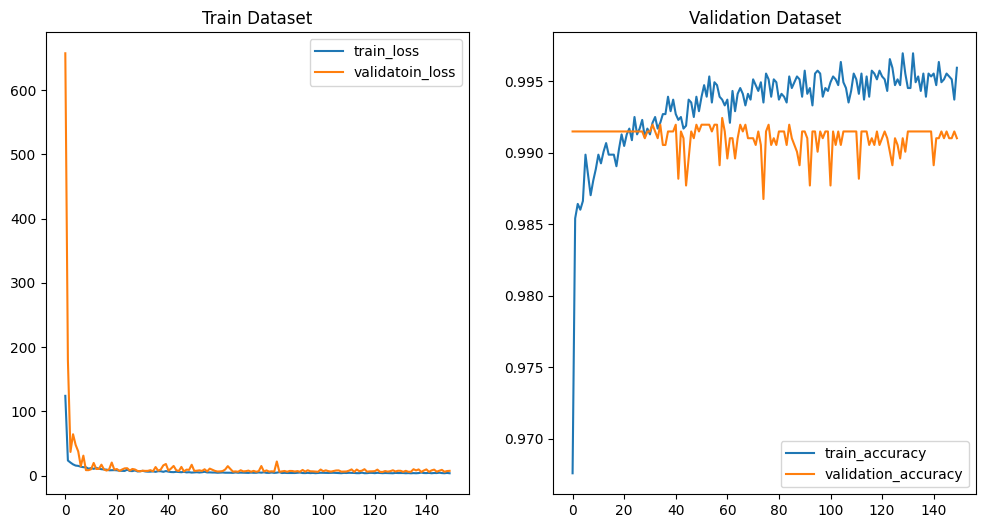

In [53]:
plt.figure(figsize = (12, 6))
plt.subplot(1, 2, 1)
plt.title('Train Dataset')
plt.plot(history.history['loss'], label = 'train_loss')
plt.plot(history.history['val_loss'], label = 'validatoin_loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.title('Validation Dataset')
plt.plot(history.history['accuracy'], label = 'train_accuracy')
plt.plot(history.history['val_accuracy'], label = 'validation_accuracy')
plt.legend()
plt.show()

In [54]:
preds = model_less_features.predict(test_df_x)
display(preds)

56/56 [==============================] - 1s 18ms/step


array([[64.18989 , 37.488914, 28.768085, ..., 50.83716 , 46.982304,
        82.22418 ],
       [65.51441 , 35.10544 , 25.940014, ..., 58.082405, 48.123726,
        84.348724],
       [64.92012 , 36.046795, 31.597244, ..., 55.80932 , 48.486824,
        79.608574],
       ...,
       [67.29493 , 41.00576 , 31.677452, ..., 64.32942 , 45.79975 ,
        76.86511 ],
       [61.13644 , 35.26789 , 29.965887, ..., 57.43748 , 44.474815,
        69.19275 ],
       [65.92402 , 37.54645 , 32.6338  , ..., 63.869823, 46.793087,
        77.16223 ]], dtype=float32)

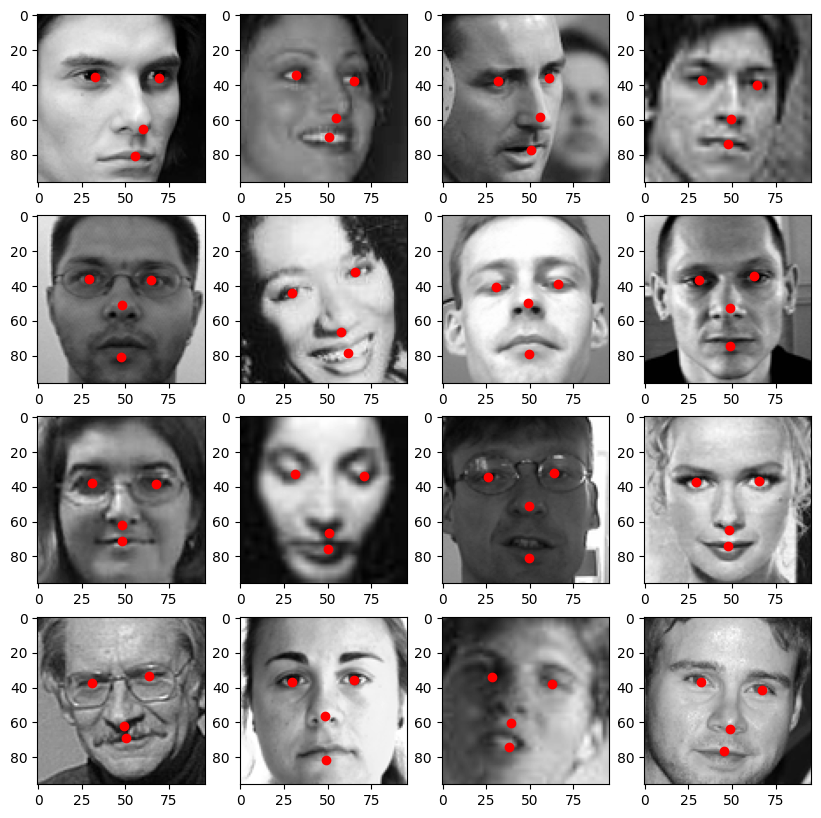

In [55]:
test_df_y_reshaped = preds.reshape(len(preds), 4, 2)
display_grid(4, 4, test_df_x, test_df_y_reshaped)

## 4. Submission results

In [37]:
lookup_table = pd.read_csv('IdLookupTable.csv')

In [38]:
lookup_table.head()

,RowId,ImageId,FeatureName,Location
0,1,1,left_eye_center_x,NaN
1,2,1,left_eye_center_y,NaN
2,3,1,right_eye_center_x,NaN
3,4,1,right_eye_center_y,NaN
4,5,1,left_eye_inner_corner_x,NaN


In [39]:
features_names = list(lookup_table['FeatureName'])
image_ids = list(lookup_table['ImageId']-1)
features_names_list = [features_names.index(f) for f in features_names]
final_preds = [preds[x][y] for x, y in zip(image_ids, features_names_list)]

In [40]:
submission_results = pd.DataFrame({'RowId': lookup_table['RowId'], 'Location': final_preds})
submission_results['Location'] = submission_results['Location'].clip(0.0, 96.0)
print(submission_results.shape)

(27124, 2)


In [41]:
submission_results.to_csv('SampleSubmission.csv', index = False)